In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain,day_of_week
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,...,5,10,0,0,1.0,1.0,2.0,47.0,@gmail.com,1
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,...,1,4,1,1,1.0,1.0,2.0,25.0,@hotmail.com,1
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,...,19,27,0,2,0.0,1.0,0.0,NaN,@yahoo.com,1
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,...,3,6,0,3,1.0,1.0,2.0,24.0,@yahoo.com,1
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,...,0,0,0,4,0.0,1.0,0.0,NaN,@hotmail.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71534,6,2019-09-02 00:00:00+08:00,127613,39,24,36,279,0,1,1,...,0,0,0,73534,0.0,1.0,0.0,NaN,@hotmail.com,0
71535,2,2019-09-02 00:00:00+08:00,127620,38,46,10,51,0,0,1,...,0,0,0,73535,1.0,1.0,2.0,30.0,@gmail.com,0
71536,2,2019-09-02 00:00:00+08:00,127696,32,808,18141,1445,0,0,0,...,0,0,0,73536,0.0,0.0,0.0,NaN,@gmail.com,0
71537,2,2019-09-02 00:00:00+08:00,127807,38,5,34,1445,2,4,4,...,0,0,1,73537,1.0,1.0,1.0,38.0,@gmail.com,0


open_flag
0    61083
1    10456
Name: country_code, dtype: int64


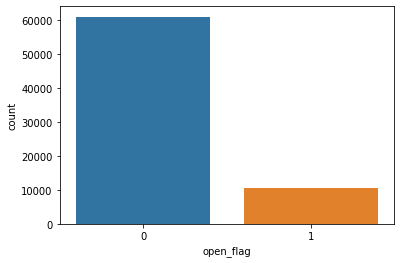

In [4]:
sns.countplot('open_flag', data=train)
print(train.groupby('open_flag').count()['country_code'])

In [5]:
TRAIN_SIZE = 3000
train_balanced = pd.DataFrame(columns=train.columns)

for i in range(2):
    df = train[train['open_flag'] == i]
    fixed_df = df.copy()
    n = int(TRAIN_SIZE / len(fixed_df))
    
    for _ in range(n): df = df.append(fixed_df, ignore_index=True)
    df = df.sample(TRAIN_SIZE, random_state=0)
    train_balanced = train_balanced.append(df, ignore_index=True)

train_balanced['open_flag'] = train_balanced['open_flag'].astype(int)
train_balanced

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain,day_of_week
0,2,2019-08-07 00:00:00+08:00,27,38,41,1,1,0,0,2,...,2,9,0,32630,1.0,1.0,1.0,37.0,@gmail.com,2
1,4,2019-08-17 00:00:00+08:00,26389,45,12,3,18,0,1,3,...,1,1,0,47356,1.0,1.0,2.0,30.0,@hotmail.com,5
2,6,2019-08-29 00:00:00+08:00,109435,41,47,2,2,0,0,2,...,1,2,0,64997,1.0,1.0,1.0,27.0,@live.com,3
3,7,2019-08-29 00:00:00+08:00,16008,52,41,1,14,0,0,3,...,36,46,0,64086,1.0,1.0,1.0,37.0,@gmail.com,3
4,1,2019-08-02 00:00:00+08:00,13296,60,104,7,12,0,0,0,...,25,34,0,24550,0.0,1.0,0.0,NaN,@gmail.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,7,2019-09-01 00:00:00+08:00,46849,63,2,0,12,1,6,14,...,17,56,1,67645,1.0,1.0,2.0,30.0,@gmail.com,6
5996,5,2019-07-17 00:00:00+08:00,84407,33,1,3,83,1,2,2,...,0,0,1,3439,1.0,1.0,2.0,23.0,@yahoo.com,2
5997,7,2019-08-15 00:00:00+08:00,118178,60,808,11,1445,1,1,1,...,0,0,1,44806,0.0,1.0,0.0,NaN,@gmail.com,3
5998,2,2019-07-30 00:00:00+08:00,64332,40,6,4,10,8,23,36,...,2,2,1,22020,1.0,1.0,2.0,25.0,@gmail.com,1


open_flag
0    3000
1    3000
Name: country_code, dtype: int64


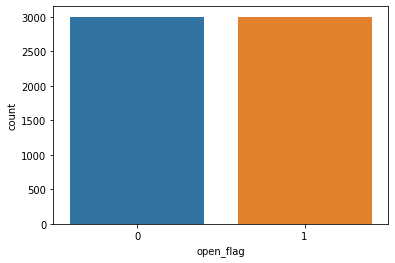

In [6]:
sns.countplot('open_flag', data=train_balanced)
print(train_balanced.groupby('open_flag').count()['country_code'])

In [7]:
def target_encoder(df, feature, label):
    ranking = df.groupby(feature).apply(lambda x: x[label].sum() / x[label].count())
    ranking = ranking.sort_values()

    encoder = {x: i for i, x in enumerate(ranking.index)}
    decoder = {i: x for i, x in enumerate(ranking.index)}
    return encoder, decoder

target_encoder(train_balanced, 'country_code', 'open_flag')

({1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6},
 {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4})

In [8]:
all_encoders = {}
all_decoders = {}

for x in ['country_code', 'domain', 'day_of_week']:
    encoder, decoder = target_encoder(train, x, 'open_flag')
    all_encoders[x] = encoder
    all_decoders[x] = decoder

    train_balanced[x + '_encoded'] = train_balanced[x].map(encoder)
    test[x + '_encoded'] = test[x].map(encoder)

print(all_encoders)
print(all_decoders)

{'country_code': {1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6}, 'domain': {'@gmail.com': 0, '@163.com': 1, '@yahoo.com': 2, '@ymail.com': 3, '@rocketmail.com': 4, '@outlook.com': 5, '@qq.com': 6, '@live.com': 7, '@icloud.com': 8, '@hotmail.com': 9, 'other': 10}, 'day_of_week': {5: 0, 1: 1, 0: 2, 3: 3, 6: 4, 4: 5, 2: 6}}
{'country_code': {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4}, 'domain': {0: '@gmail.com', 1: '@163.com', 2: '@yahoo.com', 3: '@ymail.com', 4: '@rocketmail.com', 5: '@outlook.com', 6: '@qq.com', 7: '@live.com', 8: '@icloud.com', 9: '@hotmail.com', 10: 'other'}, 'day_of_week': {0: 5, 1: 1, 2: 0, 3: 3, 4: 6, 5: 4, 6: 2}}


In [9]:
encoded_features = [
    'subject_line_length',
    'last_open_day','last_login_day', 'last_checkout_day',
    'open_count_last_10_days', 'open_count_last_30_days',
    'open_count_last_60_days', 'login_count_last_10_days',
    'login_count_last_30_days', 'login_count_last_60_days',
    'checkout_count_last_10_days', 'checkout_count_last_30_days',
    'checkout_count_last_60_days', 
    'attr_1', 'attr_2', 'attr_3',
    'country_code_encoded', 'domain_encoded', 'day_of_week_encoded'
]

In [16]:
inputs = train_balanced.loc[:, encoded_features]
test_inputs = test.loc[:, encoded_features]

labels = train_balanced['open_flag']
test_labels = test['open_flag']

In [17]:
scale = StandardScaler()
inputs = scale.fit_transform(inputs)
test_inputs = scale.transform(test_inputs)

inputs

array([[-0.42753315, -0.18928478, -0.10784973, ...,  0.01225133,
        -0.38646749,  1.62463206],
       [ 0.19985207, -0.32849242, -0.10631355, ...,  1.99895391,
         3.02967989, -1.65671636],
       [-0.15865377, -0.1604832 , -0.10708164, ...,  1.00560262,
         2.27053603, -0.01604215],
       ...,
       [ 1.54424895,  3.4925172 , -0.10016881, ...,  1.50227827,
        -0.38646749, -0.01604215],
       [-0.24828023, -0.357294  , -0.10554546, ...,  0.01225133,
        -0.38646749, -1.10982496],
       [-0.24828023, -0.37649505, -0.02259151, ..., -0.98109996,
        -0.38646749,  0.53084926]])

In [32]:
def test_model(model, inputs, labels, test_inputs, test_labels):
    print('Doing cross-validation...')
    cv_acc = cross_val_score(model, inputs, labels)
    print('CV accuracy: ', cv_acc, np.mean(cv_acc))

    print('Training model...')
    model.fit(inputs, labels)
    preds = forest.predict(test_inputs)

    plt.figure(figsize=(20, 6))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")
    plt.subplot(1,2,2)
    feature_weights = forest.feature_importances_
    plt.bar(range(len(feature_weights)), feature_weights)

    print('Test accuracy: ', accuracy_score(test_labels, preds))
    print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

    return model

Doing cross-validation...CV accuracy:  [0.80333333 0.79583333 0.795      0.7875     0.79      ] 0.7943333333333333
Training model...Test accuracy:  0.791
Test Matthews:  0.5823775029725438


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

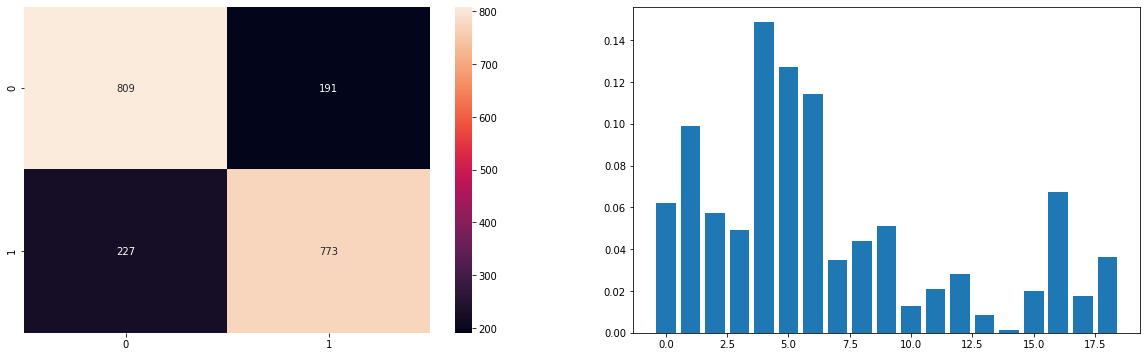

In [33]:
forest = RandomForestClassifier(n_estimators=1000)
test_model(forest, inputs, labels, test_inputs, test_labels)

In [50]:
kaggle_test = pd.read_csv('test_kaggle.csv')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id,attr_1,attr_2,attr_3,age,domain,day_of_week
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0,6,18,0,0.0,1.0,0.0,NaN,@gmail.com,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0,0,0,1,0.0,1.0,0.0,NaN,@gmail.com,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,2,2,2,2,1.0,1.0,2.0,33.0,@gmail.com,1
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,2,5,5,3,1.0,1.0,2.0,22.0,@yahoo.com,1
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0,0,2,4,0.0,1.0,0.0,NaN,@gmail.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0,0,0,55965,0.0,1.0,0.0,NaN,@gmail.com,6
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0,0,0,55966,0.0,1.0,0.0,NaN,@gmail.com,6
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0,0,0,55967,0.0,1.0,0.0,NaN,@hotmail.com,6
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0,0,0,55968,0.0,1.0,0.0,NaN,@gmail.com,6


In [51]:
for feature, encoder in all_encoders.items():
    kaggle_test[feature + '_encoded'] = kaggle_test[feature].map(encoder)

kaggle_inputs = kaggle_test.loc[:, encoded_features]
kaggle_inputs = scale.transform(kaggle_inputs)

In [52]:
kaggle_preds = forest.predict(kaggle_inputs)
kaggle_preds

array([1, 0, 0, ..., 0, 1, 1])

In [54]:
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,attr_1,attr_2,attr_3,age,domain,day_of_week,country_code_encoded,domain_encoded,day_of_week_encoded,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.0,1.0,0.0,NaN,@gmail.com,1,4,0,1,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.0,1.0,0.0,NaN,@gmail.com,1,4,0,1,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.0,1.0,2.0,33.0,@gmail.com,1,3,0,1,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.0,1.0,2.0,22.0,@yahoo.com,1,0,2,1,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.0,1.0,0.0,NaN,@gmail.com,1,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.0,1.0,0.0,NaN,@hotmail.com,6,4,9,4,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,1


In [55]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission.csv', index=False)